<a href="https://colab.research.google.com/github/nv-hiep/galaxy_classifier/blob/master/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Galaxy Classification**

Galaxy Classification with Python/R, colab.

Data Wrangling with Python

Data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data


The Galaxy Zoo 2 decision tree: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree

**Data Description**

1. images_training: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

2. solutions_training: Probability distributions for the classifications for each of the training images.

3. images_test: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. 

4. all_ones_benchmark: Sample submission file corresponding to the All Ones Benchmark

5. all_zeros_benchmark: Sample submission file corresponding to the All Zeros Benchmark

6. central_pixel_benchmark: Simple benchmark that clusters training galaxies according to the color in the center of the image and then assigns the associated probability values to like-colored images in the test set.

The first column in each solution is labeled GalaxyID; this is a randomly-generated ID that only allows you to match the probability distributions with the images.

The next 37 columns are all floating point numbers between 0 and 1 inclusive. These represent the morphology (or shape) of the galaxy in 37 different categories as identified by crowdsourced volunteer classifications as part of the Galaxy Zoo 2 project. These morphologies are related to probabilities for each category; a high number (close to 1) indicates that many users identified this morphology category for the galaxy with a high level of confidence. Low numbers for a category (close to 0) indicate the feature is likely not present. 

# Import Libraries

In [16]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import random
import shutil
import itertools
import glob
import string
import pickle
import json
import re
import chardet

from bson import json_util

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [52]:
print(tf.__version__)
tf.test.gpu_device_name()

2.6.0


''

In [2]:
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile

In [3]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Data

Download data from Galaxy Zoo: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data

**Connect and authorize google drive with google colab:**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


**Project "Galaxy Classifier" directory in google drive:**

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/galaxy_classifier/
!ls

**Data for "Galaxy Classifier" directory in google drive:**

In [53]:
%cd /content/gdrive/My Drive/data/galaxy_data/
!ls

/content/gdrive/My Drive/data/galaxy_data
plots.png  test		    train_hist_dict_rgb  training_solutions_rev1.csv
preview    train_hist_dict  training		 validation


In [8]:
data_dir = os.path.join('/content/gdrive/My Drive/data', 'galaxy_data')


training_solutions = os.path.join(data_dir, 'training_solutions_rev1.csv')
training_images    = os.path.join(data_dir, 'images_training_rev1')

print(data_dir)
print(training_solutions)
print(training_images)

/content/gdrive/My Drive/data/galaxy_data
/content/gdrive/My Drive/data/galaxy_data/training_solutions_rev1.csv
/content/gdrive/My Drive/data/galaxy_data/images_training_rev1


Read the training probablilities CVS file to a pandas dataframe.

In [9]:
# data frame
df = pd.read_csv(training_solutions)
df.head(3)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.00000,0.0,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.0,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.45995,0.0,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [10]:
# Replace Column names ('Class' -> 'C', just to shorten the codes)
df.columns = list( map(lambda s: s.replace('Class', 'C'), df.columns ) )

print(df.shape) # (61578, 38)
print(df.columns)

(61578, 38)
Index(['GalaxyID', 'C1.1', 'C1.2', 'C1.3', 'C2.1', 'C2.2', 'C3.1', 'C3.2',
       'C4.1', 'C4.2', 'C5.1', 'C5.2', 'C5.3', 'C5.4', 'C6.1', 'C6.2', 'C7.1',
       'C7.2', 'C7.3', 'C8.1', 'C8.2', 'C8.3', 'C8.4', 'C8.5', 'C8.6', 'C8.7',
       'C9.1', 'C9.2', 'C9.3', 'C10.1', 'C10.2', 'C10.3', 'C11.1', 'C11.2',
       'C11.3', 'C11.4', 'C11.5', 'C11.6'],
      dtype='object')


There are 37 classes:

'C1.1', 'C1.2', 'C1.3', 'C2.1', 'C2.2', 'C3.1', 'C3.2',
       'C4.1', 'C4.2', 'C5.1', 'C5.2', 'C5.3', 'C5.4', 'C6.1', 'C6.2', 'C7.1',
       'C7.2', 'C7.3', 'C8.1', 'C8.2', 'C8.3', 'C8.4', 'C8.5', 'C8.6', 'C8.7',
       'C9.1', 'C9.2', 'C9.3', 'C10.1', 'C10.2', 'C10.3', 'C11.1', 'C11.2',
       'C11.3', 'C11.4', 'C11.5', 'C11.6'

Number of galaxies: 61578       

# Galaxy Class definition

Only interested in three major types of galaxies:

- Elliptical galaxies (early type);
- Lenticular galaxies (in-between);
- Spiral galaxies (late type);

Select subsets of images in the Galaxy Zoo dataset based on the probabilities distributions available in the CSV file. The entire dataset is comprised of 61578 images.

- Elliptical: Class1.1 > 0.8 and Class7.1 > 0.4 (See below)
- Lenticular: Class1.1 > 0.8 and Class7.2 > 0.4
- Spiral: Class1.2 > 0.8 and Class2.1 > 0.4

In [42]:
# Get the galaxy types, as defined above
ellipticals = df[ (df['C1.1'] > 0.8) & (df['C7.1'] > 0.4) ]['GalaxyID'].tolist()
lenticulars = df[ (df['C1.1'] > 0.8) & (df['C7.2'] > 0.4) ]['GalaxyID'].tolist()
spirals     = df[ (df['C1.2'] > 0.8) & (df['C2.1'] > 0.4) ]['GalaxyID'].tolist()
# Cigar-shaped: Q1.1 > 0.8 and Q7.3 > 0.6 and Q8.3 < 0.2 (A Cigar shape is not so far away from a disk with no bulge.)
cigars = df[ (df['C1.1'] > 0.8) & (df['C7.3'] > 0.6) & (df['C8.3'] < 0.2) ]['GalaxyID'].tolist()

n_ellipticals = len(ellipticals)
n_lenticulars = len(lenticulars)
n_spirals     = len(spirals)
n_cigars      = len(cigars)

print('Total number of elliptical samples: {0}'.format(n_ellipticals) )
print('Total number of lenticular samples: {0}'.format(n_lenticulars) )
print('Total number of spiral samples: {0}'.format(n_spirals) )
print('Total number of cigar-shaped samples: {0}'.format(n_cigars) )

Total number of elliptical samples: 4555
Total number of lenticular samples: 3861
Total number of spiral samples: 3078
Total number of cigar-shaped samples: 51


Select 03 ONLY classes : Elliptical, Lenticular, Spirals

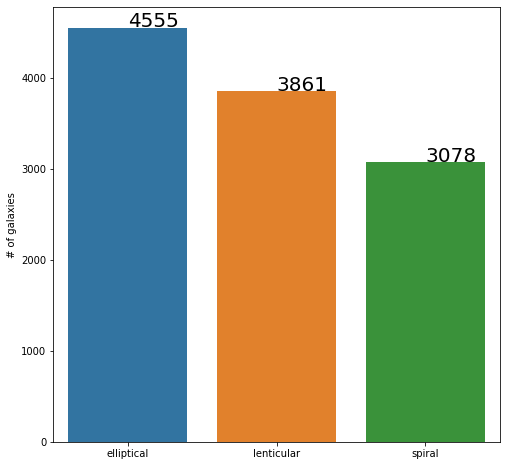

In [23]:
# Number of items of each class
plt.figure(figsize=(8,8))

x = ['elliptical', 'lenticular', 'spiral']
y = [n_ellipticals, n_lenticulars, n_spirals]

valor_graph = sns.barplot(x=x, y=y)

for index,data in enumerate(y):
  plt.text(x=index, y=data+5, s=f"{data}", fontdict=dict(fontsize=20))

plt.ylabel('# of galaxies')

plt.show()

Note: In this case, we should use class_weight method to deal with unbalanced dataset.

# Split to training/validation sets

In [26]:
# Create directories for training and validation datasets
training_dir = os.path.join(data_dir, 'training')
valid_dir    = os.path.join(data_dir, 'validation')

if not os.path.exists(data_dir):
	os.makedirs(data_dir)

if not os.path.exists(training_dir):
	os.makedirs(training_dir)

if not os.path.exists(valid_dir):
	os.makedirs(valid_dir)		

print(data_dir)

/content/gdrive/My Drive/data/galaxy_data


In [31]:
valid_dir

'/content/gdrive/My Drive/data/galaxy_data/validation'

In [27]:
# Create a function that randomly copies the images for a given class (label)
# to the corresponding training and validation directories,
# these are later used in the datasets generators:

def _split_training_valid_datasets(cat_data, category = '', train_ratio = 0.75):
	training_dest = os.path.join(training_dir, category)
	valid_dest    = os.path.join(valid_dir, category)

	if not os.path.exists(training_dest):
		os.makedirs(training_dest)

	if not os.path.exists(valid_dest):
		os.makedirs(valid_dest)

	random.shuffle(cat_data)

	idx = int( len(cat_data) * train_ratio )

	for i in cat_data[:idx]:
		shutil.copyfile( os.path.join(training_images, str(i)+'.jpg'), os.path.join(training_dest, str(i)+'.jpg') )

	for i in cat_data[idx:]:
		shutil.copyfile( os.path.join(training_images, str(i)+'.jpg'), os.path.join(valid_dest, str(i)+'.jpg') )
	
	print(category + ' <<')
	##
# End - def

In [33]:
# Split into the training and validation sets for each galaxy type
run_split = False
if run_split:
  _split_training_valid_datasets(ellipticals, category = 'elliptical', train_ratio = 0.75)
  _split_training_valid_datasets(lenticulars, category = 'lenticular', train_ratio = 0.75)
  _split_training_valid_datasets(spirals, category = 'spiral', train_ratio = 0.75)

In [45]:
# Check the total number of training and validation samples:
n_elliptical_train = len(os.listdir(os.path.join(data_dir, 'training', 'elliptical')))
n_lenticular_train = len(os.listdir(os.path.join(data_dir, 'training', 'lenticular')))
n_spiral_train     = len(os.listdir(os.path.join(data_dir, 'training', 'spiral')))
print('Total train elliptical:', n_elliptical_train)
print('Total train lenticular:', n_lenticular_train)
print('Total train spiral:', n_spiral_train)


print()
n_elliptical_val = len(os.listdir(os.path.join(data_dir, 'validation', 'elliptical')))
n_lenticular_val = len(os.listdir(os.path.join(data_dir, 'validation', 'lenticular')))
n_spiral_val     = len(os.listdir(os.path.join(data_dir, 'validation', 'spiral')))
print('Total validation elliptical:', n_elliptical_val)
print('Total validation lenticular:', n_lenticular_val)
print('Total validation spiral:', n_spiral_val)

Total train elliptical: 3416
Total train lenticular: 2895
Total train spiral: 2308

Total validation elliptical: 1139
Total validation lenticular: 966
Total validation spiral: 770


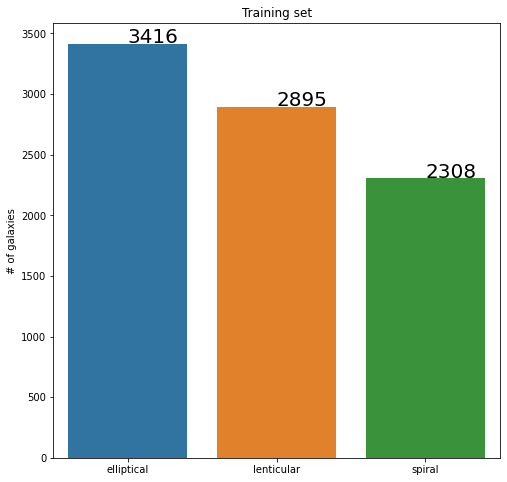

In [46]:
# Number of items of each class
plt.figure(figsize=(8,8))

x = ['elliptical', 'lenticular', 'spiral']
y = [n_elliptical_train, n_lenticular_train, n_spiral_train]

valor_graph = sns.barplot(x=x, y=y)

for index,data in enumerate(y):
  plt.text(x=index , y =data+5 , s=f"{data}" , fontdict=dict(fontsize=20))

plt.ylabel('# of galaxies')
plt.title('Training set')

plt.show()

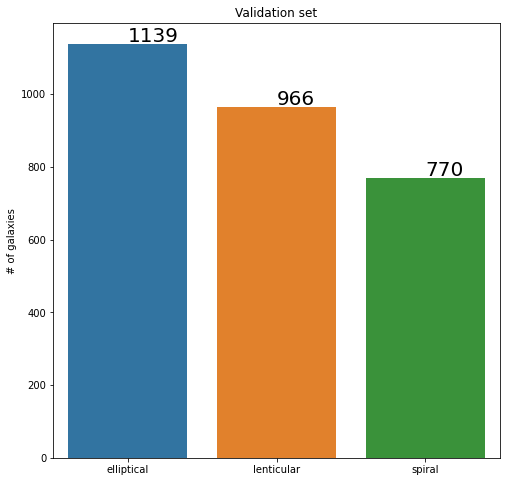

In [47]:
# Number of items of each class
plt.figure(figsize=(8,8))

# Total validation elliptical: 1139
# Total validation lenticular: 966
# Total validation spiral: 770

x = ['elliptical', 'lenticular', 'spiral']
y = [n_elliptical_val, n_lenticular_val, n_spiral_val]

valor_graph = sns.barplot(
    x= x,
    y= y
)

for index,data in enumerate(y):
  plt.text(x=index , y =data+5 , s=f"{data}" , fontdict=dict(fontsize=20))

plt.ylabel('# of galaxies')
plt.title('Validation set')

plt.show()

# Plot some samples

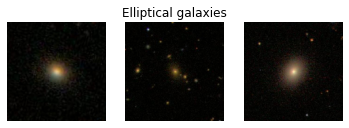

In [48]:
from keras_preprocessing import image
# Finally, show a few examples from each galaxy class:

# elliptical class
plt.figure()
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', 'elliptical'))[0:3]):
    img = image.load_img(os.path.join(data_dir, 'training', 'elliptical', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    
    if num == 1:
      plt.title('Elliptical galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

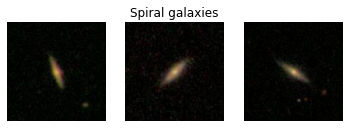

In [37]:
# spiral class
plt.figure()
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', 'spiral'))[0:3]):
    img = image.load_img(os.path.join(data_dir, 'training', 'spiral', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)

    if num == 1:
      plt.title('Spiral galaxies')

    plt.axis('off')
    plt.imshow(img)
plt.show()
plt.close()

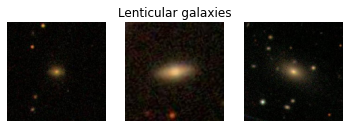

In [38]:
# lenticular class
plt.figure()
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', 'lenticular'))[0:3]):
    img = image.load_img(os.path.join(data_dir, 'training', 'lenticular', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)

    if num == 1:
      plt.title('Lenticular galaxies')

    plt.axis('off')
    plt.imshow(img)
plt.show()
plt.close()

# Conclusion



1.   Downloaded data.
2.   Select classes of galaxies.
3.   Split dataset into training/test sets
4.   The number of samples for each classes are different, meaning that the training/valiadtion sets are imbalanced. Need to consider the weights for imbalanced dataset when training the model.



